# This notebook continues to compare similarity scores within TE repClass with modifications
- reverse complement and reverse sequences included in the pair-wise alignment to check potential dsRNA formation with each other
- remove fw-fw combination score to see the effect only of different direction binding
    + do fw-rvcmp, fw-rv, ( exlude all same direction alignment)
    + do fw-fw exlusion only ( in case change of coding direction changes alignment scores since only of ways of alignment are accessed though multiple ways are possible)

In [199]:
import seaborn as sn

In [1]:
import math

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, pairwise2
from itertools import combinations

/home/lucy/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
from scipy import stats

In [4]:
from matplotlib.patches import Patch

In [5]:
import os

In [6]:
import sequence_comparison as seqComp

## load data

In [9]:
rv_cmp_fasta_folder = "./sequence_similarity_input/score_rv_comple_trial/"
rv_cmp_result_folder = './sequence_similarity_results/score_rv_comple_result/'

In [12]:
squire_indi = pd.read_csv("./squire_all_Deseq_indiv_locus.csv", header = 0, index_col = 0 )
squire_indi.head()

,TE_ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,element_type,TE_name,TE_index,repName,repFamily,repClass,genoName,genoStart,genoEnd,strand,df_index_repName,seqLen
11357,chr17|26318143|26318201|Tigger12:TcMar-Tigger:...,6.651258,-0.841285,0.716066,-1.174872,0.592771,1.0,TE,Tigger12:TcMar-Tigger:DNA,Tigger12:TcMar-Tigger:DNA_236,Tigger12,TcMar-Tigger,DNA,chr17,26318143,26318201,-,11357_Tigger12,58
6327,chr4|11817737|11817796|Tigger19b:TcMar-Tigger:...,10.586987,-0.203290,0.607192,-0.334804,0.929015,1.0,TE,Tigger19b:TcMar-Tigger:DNA,Tigger19b:TcMar-Tigger:DNA_288,Tigger19b,TcMar-Tigger,DNA,chr4,11817737,11817796,-,6327_Tigger19b,59
820,chr11|115913825|115913885|MamRTE1:RTE-BovB:LIN...,16.156902,-0.127513,0.402174,-0.317059,0.987502,1.0,TE,MamRTE1:RTE-BovB:LINE,MamRTE1:RTE-BovB:LINE_283,MamRTE1,RTE-BovB,LINE,chr11,115913825,115913885,+,820_MamRTE1,60
7777,"chr11|58498306|58498366|MTD:ERVL-MaLR:LTR|169|+,.",5.234425,0.899249,0.784343,1.146500,0.558834,1.0,TE,MTD:ERVL-MaLR:LTR,MTD:ERVL-MaLR:LTR_169,MTD,ERVL-MaLR,LTR,chr11,58498306,58498366,+,7777_MTD,60
9814,"chr10|126903390|126903452|ID4_v:ID:SINE|183|+,.",6.713422,0.503397,0.658301,0.764692,0.785880,1.0,TE,ID4_v:ID:SINE,ID4_v:ID:SINE_183,ID4_v,ID,SINE,chr10,126903390,126903452,+,9814_ID4_v,62


In [14]:
squire_repClass_dict = dict( zip( squire_indi['df_index_repName'] , squire_indi['repClass'] ))

In [138]:
tcps_indiv= pd.read_csv("/home/lucy/Dropbox/TCPS_TE_results/TE_indi_deseq_zc.csv", header = 0, index_col = 0)
tcps_indiv.head()

,TE name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,repName,repClass,repFamily
0,L2,0.097405,0.197787,1.457064,0.135744,0.892024,0.999991,L2,LINE,L2
1,AluSg,0.493240,1.038439,0.909837,1.141346,0.253726,0.999991,AluSg,SINE,Alu
2,L1PA8A,1.504698,-0.263127,0.834217,-0.315418,0.752444,0.999991,L1PA8A,LINE,L1
3,L1MDb,0.179092,0.166453,1.381934,0.120449,0.904127,0.999991,L1MDb,LINE,L1
4,AluSp,0.033562,0.514654,3.312685,0.155358,0.876539,0.999991,AluSp,SINE,Alu


In [142]:
tcps_repClass_dict = dict( zip( tcps_indiv['TE name'], tcps_indiv['repClass'] ))

In [10]:
# load one example
squire_mut_up50 = pd.read_csv( rv_cmp_result_folder+ 'squire_mut_up_top50_pairwise_identity.csv', header = 0, index_col = None)

In [11]:
squire_mut_up50.head()

,ID1,ID2,PercentIdentity,Alignment_str
0,9437_RLTR4_MM-int_rvcmp,9437_RLTR4_MM-int_cmp,64.314869,aggggcc-ctgattccgagggg---tgtt-tcctcgcttaagg-ga...
1,9437_RLTR4_MM-int_rvcmp,9437_RLTR4_MM-int,64.081633,-ag---g--ggc-cct-g--a-t--t----cc--g--ag-------...
2,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm_rvcmp,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...
3,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm_cmp,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...
4,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...


In [ ]:
squire_mut_up50

In [45]:
result_dir = './sequence_similarity_results/score_rv_comple_result/'
score_fnames = pd.Series( os.listdir( result_dir ) )

In [48]:
squire_fnames = score_fnames[score_fnames.str.startswith('squire')]
squire_fnames.sort_values( inplace=True ,ignore_index=True )
squire_fnames

0     squire_mut_up_last50_pairwise_identity.csv
1      squire_mut_up_top10_pairwise_identity.csv
2      squire_mut_up_top20_pairwise_identity.csv
3      squire_mut_up_top50_pairwise_identity.csv
4          squire_rand10_1_pairwise_identity.csv
5          squire_rand10_2_pairwise_identity.csv
6          squire_rand10_3_pairwise_identity.csv
7          squire_rand20_1_pairwise_identity.csv
8          squire_rand20_2_pairwise_identity.csv
9          squire_rand20_3_pairwise_identity.csv
10         squire_rand50_1_pairwise_identity.csv
11         squire_rand50_2_pairwise_identity.csv
12         squire_rand50_3_pairwise_identity.csv
13      squire_wt_up_top10_pairwise_identity.csv
14      squire_wt_up_top20_pairwise_identity.csv
15      squire_wt_up_top33_pairwise_identity.csv
dtype: object

In [49]:
tcps_fnames = score_fnames[score_fnames.str.startswith('tcps')]
tcps_fnames.sort_values( inplace=True ,ignore_index=True )
tcps_fnames

0         tcps_ad_up_all_pairwise_identity.csv
1          tcps_rand10_1_pairwise_identity.csv
2          tcps_rand10_2_pairwise_identity.csv
3          tcps_rand10_3_pairwise_identity.csv
4          tcps_rand20_1_pairwise_identity.csv
5          tcps_rand20_2_pairwise_identity.csv
6          tcps_rand20_3_pairwise_identity.csv
7          tcps_rand50_1_pairwise_identity.csv
8          tcps_rand50_2_pairwise_identity.csv
9          tcps_rand50_3_pairwise_identity.csv
10    tcps_ser_up_last50_pairwise_identity.csv
11     tcps_ser_up_top10_pairwise_identity.csv
12     tcps_ser_up_top20_pairwise_identity.csv
13     tcps_ser_up_top50_pairwise_identity.csv
dtype: object

## add transcript direction columns

In [15]:
def add_class_direction_info( identity_df, repClass_dict ):
    """ This function extract TE repClass/subF and transcript direction information from the identity score df"""
    
    # declare list for original TE name without suffix
    orig_id1s = []
    orig_id2s = []
    
    # declare list for transcript directions ( fw, cmp, rvcmp)
    direction1s= []
    direction2s = []
    
    for id1,id2 in identity_df[['ID1' ,'ID2']].values:

        # first check id1 
        id1_ls = id1.split("_")
        if( id1_ls[-1].endswith('cmp') ):

            # update original id 
            orig_id1s.append( "_".join( id1_ls[0:-1]) )
            
            # update dirction
            direction1s.append( id1_ls[-1] )
            
        else:
            orig_id1s.append( id1)
            direction1s.append( 'fw' )
            
        # check id2 in the same way
        id2_ls = id2.split("_")
        if( id2_ls[-1].endswith('cmp') ):
            orig_id2s.append( "_".join( id2_ls[0:-1]))
            direction2s.append( id2_ls[-1] )
            
        else:
            orig_id2s.append( id2)
            direction2s.append( 'fw')
        
    
    # add original TE name to result df
    identity_df['ID1_original'] = orig_id1s
    identity_df['ID2_original'] = orig_id2s
    # add direction s to the result df
    identity_df['Direction1'] = direction1s
    identity_df['Direction2'] = direction2s

    #map with dict
    identity_df['repClass1'] = [ repClass_dict[k] for k in identity_df['ID1_original'] ]
    identity_df['repClass2'] = [ repClass_dict[k] for k in identity_df['ID2_original'] ]
    
    return identity_df
    

In [16]:
annotated_test_df = add_class_direction_info( squire_mut_up50, squire_repClass_dict )

In [17]:
annotated_test_df.head()

,ID1,ID2,PercentIdentity,Alignment_str,ID1_original,ID2_original,Direction1,Direction2,repClass1,repClass2
0,9437_RLTR4_MM-int_rvcmp,9437_RLTR4_MM-int_cmp,64.314869,aggggcc-ctgattccgagggg---tgtt-tcctcgcttaagg-ga...,9437_RLTR4_MM-int,9437_RLTR4_MM-int,rvcmp,cmp,LTR,LTR
1,9437_RLTR4_MM-int_rvcmp,9437_RLTR4_MM-int,64.081633,-ag---g--ggc-cct-g--a-t--t----cc--g--ag-------...,9437_RLTR4_MM-int,9437_RLTR4_MM-int,rvcmp,fw,LTR,LTR
2,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm_rvcmp,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,11292_RLTR4_Mm,rvcmp,rvcmp,LTR,LTR
3,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm_cmp,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,11292_RLTR4_Mm,rvcmp,cmp,LTR,LTR
4,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,11292_RLTR4_Mm,rvcmp,fw,LTR,LTR


In [18]:
test_dfs = seqComp.keep_within_class_TE_pairs( [annotated_test_df], df_index_names = ['squire_mut_up_top50'] ,  verbose = True)

squire_mut_up_top50
Original df has 11175 elements
Filtered df has 9114 elements
0.8155704697986578 left



In [20]:
test_df_full = test_dfs[0]

In [29]:
test_df_full[['Direction1' ,'Direction2']].value_counts()

Direction1  Direction2
cmp         fw            1046
rvcmp       cmp           1046
            fw            1046
cmp         cmp            996
            rvcmp          996
fw          cmp            996
            fw             996
            rvcmp          996
rvcmp       rvcmp          996
Name: count, dtype: int64

In [42]:
m = test_df_full['PercentIdentity'].mean()
s = test_df_full['PercentIdentity'].std()
print( f"full df avg. score = {m}, std = {s}")

full df avg. score = 33.00370611235437, std = 20.964675284043036


## trial 1: exclude only fw-fw combination

In [31]:
test_df_trial1 = test_df_full[ (test_df_full['Direction1'] != 'fw') | (test_df_full['Direction2'] != 'fw' ) ]

In [32]:
print( test_df_full.shape)
print( test_df_trial1.shape)

(9114, 10)
(8118, 10)


In [33]:
test_df_trial1[['Direction1' ,'Direction2']].value_counts()

Direction1  Direction2
cmp         fw            1046
rvcmp       cmp           1046
            fw            1046
cmp         cmp            996
            rvcmp          996
fw          cmp            996
            rvcmp          996
rvcmp       rvcmp          996
Name: count, dtype: int64

In [34]:
test_df_trial1.head()

,ID1,ID2,PercentIdentity,Alignment_str,ID1_original,ID2_original,Direction1,Direction2,repClass1,repClass2
0,9437_RLTR4_MM-int_rvcmp,9437_RLTR4_MM-int_cmp,64.314869,aggggcc-ctgattccgagggg---tgtt-tcctcgcttaagg-ga...,9437_RLTR4_MM-int,9437_RLTR4_MM-int,rvcmp,cmp,LTR,LTR
1,9437_RLTR4_MM-int_rvcmp,9437_RLTR4_MM-int,64.081633,-ag---g--ggc-cct-g--a-t--t----cc--g--ag-------...,9437_RLTR4_MM-int,9437_RLTR4_MM-int,rvcmp,fw,LTR,LTR
2,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm_rvcmp,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,11292_RLTR4_Mm,rvcmp,rvcmp,LTR,LTR
3,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm_cmp,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,11292_RLTR4_Mm,rvcmp,cmp,LTR,LTR
4,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,11292_RLTR4_Mm,rvcmp,fw,LTR,LTR


In [43]:
m = test_df_trial1['PercentIdentity'].mean()
s = test_df_trial1['PercentIdentity'].std()
print( f"exclude fw-fw df avg. score = {m}, std = {s}")

exclude fw-fw df avg. score = 32.80393327817568, std = 20.460796121100067


## trial 2: exclude all same direction combination

In [38]:
test_df_trial2 = test_df_full[ (test_df_full['Direction1'] != test_df_full['Direction2']) ]

In [39]:
test_df_trial2.shape

(6126, 10)

In [40]:
test_df_trial2.head()

,ID1,ID2,PercentIdentity,Alignment_str,ID1_original,ID2_original,Direction1,Direction2,repClass1,repClass2
0,9437_RLTR4_MM-int_rvcmp,9437_RLTR4_MM-int_cmp,64.314869,aggggcc-ctgattccgagggg---tgtt-tcctcgcttaagg-ga...,9437_RLTR4_MM-int,9437_RLTR4_MM-int,rvcmp,cmp,LTR,LTR
1,9437_RLTR4_MM-int_rvcmp,9437_RLTR4_MM-int,64.081633,-ag---g--ggc-cct-g--a-t--t----cc--g--ag-------...,9437_RLTR4_MM-int,9437_RLTR4_MM-int,rvcmp,fw,LTR,LTR
3,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm_cmp,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,11292_RLTR4_Mm,rvcmp,cmp,LTR,LTR
4,9437_RLTR4_MM-int_rvcmp,11292_RLTR4_Mm,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,11292_RLTR4_Mm,rvcmp,fw,LTR,LTR
6,9437_RLTR4_MM-int_rvcmp,12455_RLTR4_Mm_cmp,21.603499,aggggccctgattccgaggggtgtttcctcgcttaagggaaataag...,9437_RLTR4_MM-int,12455_RLTR4_Mm,rvcmp,cmp,LTR,LTR


In [44]:
m = test_df_trial2['PercentIdentity'].mean()
s = test_df_trial2['PercentIdentity'].std()
print( f"Diff-direction df avg. score = {m}, std = {s}")

Diff-direction df avg. score = 32.20950637295055, std = 18.869538673483508


## squire data pipeline

In [71]:
# load all df
squire_df_ls = []
for f in squire_fnames:
    d= pd.read_csv( result_dir + f, header = 0, index_col = None)
    squire_df_ls.append( d)

In [72]:
# annotate
for d in squire_df_ls:
    d = add_class_direction_info( d, squire_repClass_dict )

In [73]:
squire_fnames

0     squire_mut_up_last50_pairwise_identity.csv
1      squire_mut_up_top10_pairwise_identity.csv
2      squire_mut_up_top20_pairwise_identity.csv
3      squire_mut_up_top50_pairwise_identity.csv
4          squire_rand10_1_pairwise_identity.csv
5          squire_rand10_2_pairwise_identity.csv
6          squire_rand10_3_pairwise_identity.csv
7          squire_rand20_1_pairwise_identity.csv
8          squire_rand20_2_pairwise_identity.csv
9          squire_rand20_3_pairwise_identity.csv
10         squire_rand50_1_pairwise_identity.csv
11         squire_rand50_2_pairwise_identity.csv
12         squire_rand50_3_pairwise_identity.csv
13      squire_wt_up_top10_pairwise_identity.csv
14      squire_wt_up_top20_pairwise_identity.csv
15      squire_wt_up_top33_pairwise_identity.csv
dtype: object

In [74]:
squire_f_inds = [ 'mut_up_last50' ] + [ f'mut_up_top{n}' for n in [10,20, 50] ]

In [75]:
rand_inds = [ f'rand{n}_{r}' for n in [10,20,50] for r in [1,2,3] ]
#rand_inds

In [76]:
wt_inds = [ f'wt_up_top{n}' for n in [10,20, 33] ]

In [77]:
squire_f_inds = squire_f_inds + rand_inds + wt_inds 

In [78]:
assert( len( squire_f_inds) == len( squire_fnames) )

In [79]:
squire_cond = conditions = [ 'mut_up' for i in range(4) ] + ['control' for i in range(len( rand_inds))] + [ 'wt_up' for i in range(3)] 

In [80]:
assert( len( squire_cond) == len( squire_fnames) )

In [81]:
squire_total_nums = [ 50, 10, 20, 50 ] + [ 10 for i in range(3)] + [ 20 for i in range(3)] + [ 50 for i in range(3)] + [10,20,33]

In [82]:
squire_total_nums = pd.Series( squire_total_nums )

In [83]:
squire_total_nums = squire_total_nums *3

In [84]:
squire_df_ls[0].head()

,ID1,ID2,PercentIdentity,Alignment_str,ID1_original,ID2_original,Direction1,Direction2,repClass1,repClass2
0,8873_IAPLTR1a_Mm_rvcmp,8873_IAPLTR1a_Mm_cmp,64.391691,tgttatt-agacgcgttctcacga-c-cggccag-ga-aagacg-c...,8873_IAPLTR1a_Mm,8873_IAPLTR1a_Mm,rvcmp,cmp,LTR,LTR
1,8873_IAPLTR1a_Mm_rvcmp,8873_IAPLTR1a_Mm,65.281899,tgttattag--a-c-gcgttctcacgac---cggccagg--a-aag...,8873_IAPLTR1a_Mm,8873_IAPLTR1a_Mm,rvcmp,fw,LTR,LTR
2,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int_rvcmp,15.911237,--t--------g------------tta-t-t-a-------g-----...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,rvcmp,LTR,LTR
3,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int_cmp,15.911237,t---g----t----t-------------a-----------------...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,cmp,LTR,LTR
4,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int,15.911237,--tg----t--t--a-------------tt----------------...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,fw,LTR,LTR


In [126]:
# generate summary df from the full df
squire_full_sum_df = seqComp.get_summary_df( squire_df_ls, squire_f_inds, squire_cond, squire_total_nums )

mut_up_last50
Original df has 11175 elements
Filtered df has 8718 elements
0.7801342281879194 left

mut_up_top10
Original df has 435 elements
Filtered df has 354 elements
0.8137931034482758 left

mut_up_top20
Original df has 1770 elements
Filtered df has 1311 elements
0.7406779661016949 left

mut_up_top50
Original df has 11175 elements
Filtered df has 9114 elements
0.8155704697986578 left

rand10_1
Original df has 435 elements
Filtered df has 174 elements
0.4 left

rand10_2
Original df has 435 elements
Filtered df has 147 elements
0.33793103448275863 left

rand10_3
Original df has 435 elements
Filtered df has 282 elements
0.6482758620689655 left

rand20_1
Original df has 1770 elements
Filtered df has 762 elements
0.43050847457627117 left

rand20_2
Original df has 1770 elements
Filtered df has 681 elements
0.3847457627118644 left

rand20_3
Original df has 1770 elements
Filtered df has 645 elements
0.3644067796610169 left

rand50_1
Original df has 11175 elements
Filtered df has 4344 elem

### get fw-fw exclusion summary df

In [91]:
# extract dfs
exclude_fw_df_ls = []
for d in squire_df_ls:
    d2 =  d[ (d['Direction1'] != 'fw') | (d['Direction2'] != 'fw' ) ]
    exclude_fw_df_ls.append( d2)
    
    

In [92]:
# generate summary df from the dfs
squire_fw_exclusion_sum_df = seqComp.get_summary_df( exclude_fw_df_ls, squire_f_inds, squire_cond, squire_total_nums )

mut_up_last50
Original df has 9950 elements
Filtered df has 7766 elements
0.7805025125628141 left

mut_up_top10
Original df has 390 elements
Filtered df has 318 elements
0.8153846153846154 left

mut_up_top20
Original df has 1580 elements
Filtered df has 1172 elements
0.7417721518987341 left

mut_up_top50
Original df has 9950 elements
Filtered df has 8118 elements
0.8158793969849246 left

rand10_1
Original df has 390 elements
Filtered df has 158 elements
0.40512820512820513 left

rand10_2
Original df has 390 elements
Filtered df has 134 elements
0.3435897435897436 left

rand10_3
Original df has 390 elements
Filtered df has 254 elements
0.6512820512820513 left

rand20_1
Original df has 1580 elements
Filtered df has 684 elements
0.43291139240506327 left

rand20_2
Original df has 1580 elements
Filtered df has 612 elements
0.38734177215189874 left

rand20_3
Original df has 1580 elements
Filtered df has 580 elements
0.3670886075949367 left

rand50_1
Original df has 9950 elements
Filtered df 

In [93]:
squire_fw_exclusion_sum_df.head(10)

,mut_up_last50,mut_up_top10,mut_up_top20,mut_up_top50,rand10_1,rand10_2,rand10_3,rand20_1,rand20_2,rand20_3,rand50_1,rand50_2,rand50_3,wt_up_top10,wt_up_top20,wt_up_top33
avg_pctIdentity,30.909894,33.746106,34.210279,32.803933,55.99464,44.038349,35.990534,40.684279,46.57462,38.182816,37.004486,33.830652,37.967008,32.779498,36.672487,36.624783
std_pctIdentity,19.767827,21.157126,21.76716,20.460796,7.014331,17.627964,17.772531,17.377727,17.32613,19.142623,18.905451,19.283986,18.164673,21.723023,19.304231,18.712723
sum_pctIdentity,240046.233983,10731.261591,40094.447129,266302.330352,8847.153169,5901.13882,9141.595601,27828.047005,28503.667141,22146.033464,143503.39856,120910.751524,127493.212573,5441.396723,23030.322094,66327.482789
num_element_sampled,150,30,60,150,30,30,30,60,60,60,150,150,150,30,60,99
num_combination_all,11175,435,1770,11175,435,435,435,1770,1770,1770,11175,11175,11175,435,1770,4851
num_combination_left,7766,318,1172,8118,158,134,254,684,612,580,3878,3574,3358,166,628,1811
adjusted_avg_pctIdentity,21.480647,24.669567,22.65223,23.830186,20.338283,13.565836,21.015162,15.72206,16.103767,12.511883,12.841467,10.819754,11.408789,12.508958,13.011481,13.67295
adjusted_std_pctIdentity,13.737534,15.466589,14.413058,14.863601,2.547734,5.430223,10.377524,6.715461,5.99073,6.272724,6.560657,6.167424,5.458342,8.289705,6.849185,6.985929
condition,mut_up,mut_up,mut_up,mut_up,control,control,control,control,control,control,control,control,control,wt_up,wt_up,wt_up


### get diff-direction summary df

In [99]:
# extract dfs
diff_direction_df_ls = []
for d in squire_df_ls:
    d2 =  d[ d['Direction1'] !=  d['Direction2']  ]
    diff_direction_df_ls.append( d2)

In [100]:
len( diff_direction_df_ls)

16

In [124]:
diff_direction_df_ls[0].shape

(7500, 10)

In [125]:
squire_df_ls[0].shape

(11175, 10)

In [101]:
# generate summary df from the dfs
squire_diff_dir_sum_df = seqComp.get_summary_df( diff_direction_df_ls, squire_f_inds, squire_cond, squire_total_nums )

mut_up_last50
Original df has 7500 elements
Filtered df has 5862 elements
0.7816 left

mut_up_top10
Original df has 300 elements
Filtered df has 246 elements
0.82 left

mut_up_top20
Original df has 1200 elements
Filtered df has 894 elements
0.745 left

mut_up_top50
Original df has 7500 elements
Filtered df has 6126 elements
0.8168 left

rand10_1
Original df has 300 elements
Filtered df has 126 elements
0.42 left

rand10_2
Original df has 300 elements
Filtered df has 108 elements
0.36 left

rand10_3
Original df has 300 elements
Filtered df has 198 elements
0.66 left

rand20_1
Original df has 1200 elements
Filtered df has 528 elements
0.44 left

rand20_2
Original df has 1200 elements
Filtered df has 474 elements
0.395 left

rand20_3
Original df has 1200 elements
Filtered df has 450 elements
0.375 left

rand50_1
Original df has 7500 elements
Filtered df has 2946 elements
0.3928 left

rand50_2
Original df has 7500 elements
Filtered df has 2718 elements
0.3624 left

rand50_3
Original df has

In [102]:
squire_diff_dir_sum_df.shape

(9, 16)

In [104]:
squire_diff_dir_sum_df

,mut_up_last50,mut_up_top10,mut_up_top20,mut_up_top50,rand10_1,rand10_2,rand10_3,rand20_1,rand20_2,rand20_3,rand50_1,rand50_2,rand50_3,wt_up_top10,wt_up_top20,wt_up_top33
avg_pctIdentity,30.739405,34.102781,33.555517,32.209506,55.695284,44.775884,36.927939,40.993186,46.490317,38.519493,37.082408,34.010205,38.172696,34.383748,37.117283,36.7029
std_pctIdentity,19.063193,20.412901,19.592281,18.869539,6.652145,17.301571,18.160241,17.041832,16.87392,18.728307,18.644691,19.151825,18.113664,22.134289,19.017316,18.205514
sum_pctIdentity,180194.389852,8389.284026,29998.632528,197315.436041,7017.605846,4835.795451,7311.73197,21644.402006,22036.410235,17333.771892,109244.773366,92439.737353,97569.41137,4538.654746,18038.999452,50760.110128
num_element_sampled,150,30,60,150,30,30,30,60,60,60,150,150,150,30,60,99
num_combination_all,11175,435,1770,11175,435,435,435,1770,1770,1770,11175,11175,11175,435,1770,4851
num_combination_left,5862,246,894,6126,126,108,198,528,474,450,2946,2718,2556,132,486,1383
adjusted_avg_pctIdentity,16.124778,19.28571,16.94838,17.656862,16.132427,11.116771,16.808579,12.228476,12.449949,9.793091,9.775819,8.272012,8.731044,10.433689,10.191525,10.463845
adjusted_std_pctIdentity,9.99986,11.543847,9.895762,10.344053,1.926828,4.295562,8.266041,5.083665,4.518779,4.761434,4.915191,4.658135,4.143045,6.716612,5.221704,5.190317
condition,mut_up,mut_up,mut_up,mut_up,control,control,control,control,control,control,control,control,control,wt_up,wt_up,wt_up


### generate avg.score plots

In [105]:
condition_colors = {
    'control': 'gray',
    'mut_up': 'salmon',
    'wt_up':'cornflowerblue'
}

In [108]:
squire_fw_exclusion_sum_df = squire_fw_exclusion_sum_df.T

In [111]:
squire_fw_exclusion_sum_df.sort_values( by = [ 'num_element_sampled', 'condition'], inplace =True )

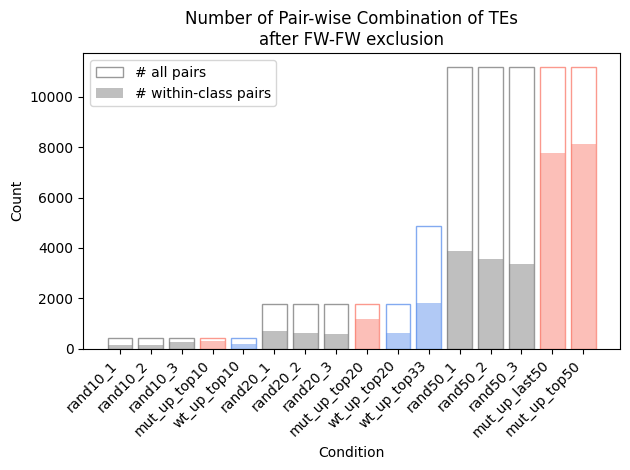

In [133]:
# Example data
summary_df = squire_fw_exclusion_sum_df.copy()


x_pos = np.arange(summary_df.shape[0])
heights1 = summary_df['num_combination_all']  # dataset 1
heights2 = summary_df['num_combination_left' ]   # dataset 2

all_pair_colors = [condition_colors[cond] for cond in summary_df['condition'] ]


bar_width = 0.8 # need to adjust

# Plot side-by-side histograms
plt.bar(x_pos , heights1, width=bar_width, label='# all pairs', alpha=0.8, edgecolor=all_pair_colors, facecolor='none',)
plt.bar(x_pos , heights2, width=bar_width, label='# within-class pairs', alpha=0.5, color =all_pair_colors)

# Add labels and legend
plt.xticks(x_pos, summary_df.index, rotation = 45, ha = 'right')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Number of Pair-wise Combination of TEs\nafter FW-FW exclusion')
plt.legend()
plt.tight_layout()
plt.show()


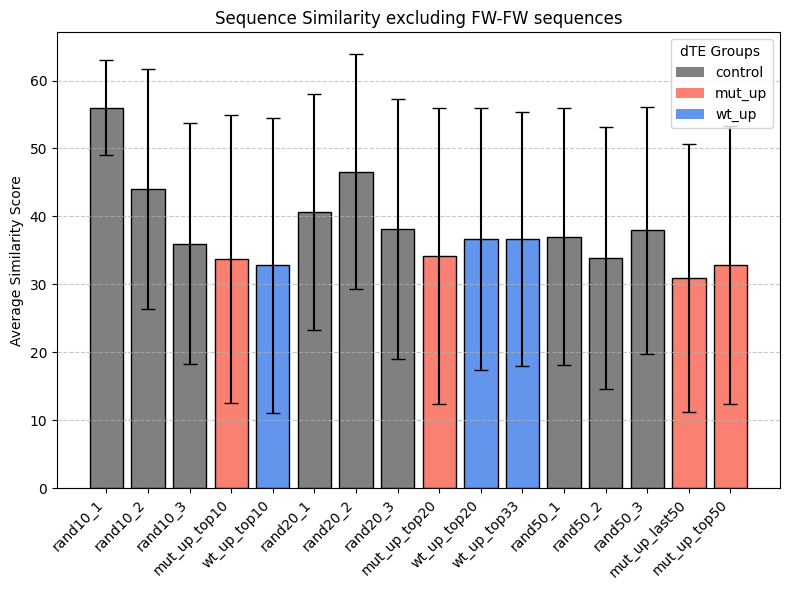

In [112]:
summary_df = squire_fw_exclusion_sum_df.copy()

bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['avg_pctIdentity'] , yerr=summary_df['std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')


plt.ylabel('Average Similarity Score')
plt.title('Sequence Similarity excluding FW-FW sequences')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [113]:
squire_diff_dir_sum_df = squire_diff_dir_sum_df.T

In [114]:
squire_diff_dir_sum_df.sort_values( by = [ 'num_element_sampled', 'condition'], inplace =True )

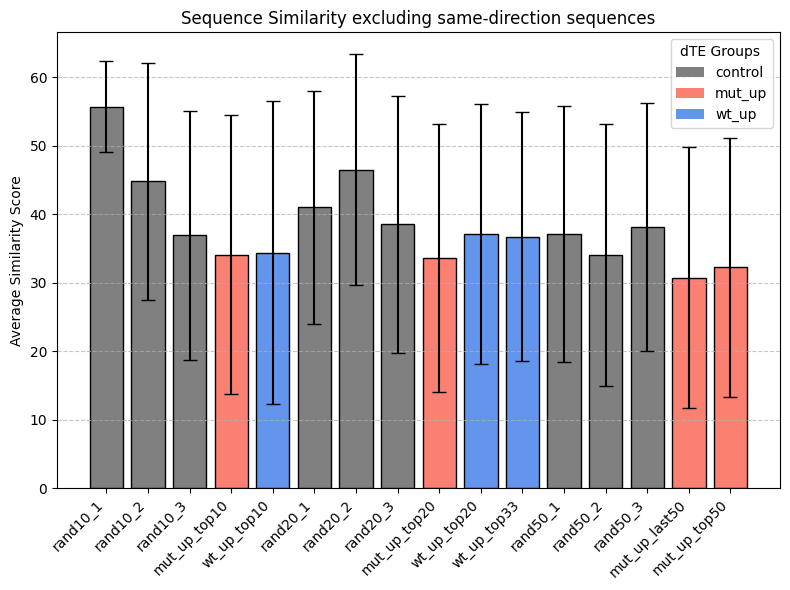

In [115]:
summary_df = squire_diff_dir_sum_df.copy()

bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['avg_pctIdentity'] , yerr=summary_df['std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')


plt.ylabel('Average Similarity Score')
plt.title('Sequence Similarity excluding same-direction sequences')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


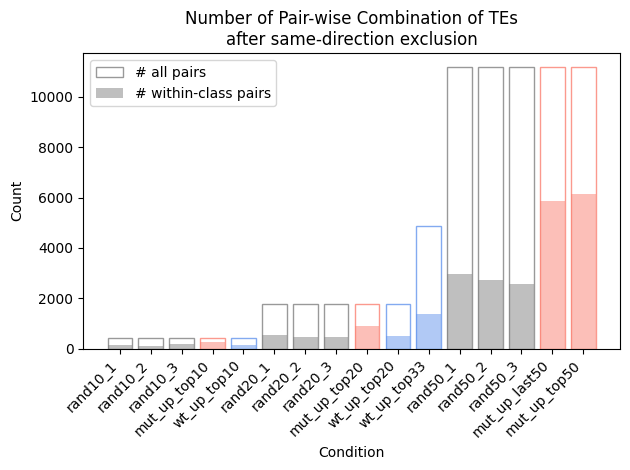

In [134]:
# Example data
summary_df = squire_diff_dir_sum_df.copy()


x_pos = np.arange(summary_df.shape[0])
heights1 = summary_df['num_combination_all']  # dataset 1
heights2 = summary_df['num_combination_left' ]   # dataset 2

all_pair_colors = [condition_colors[cond] for cond in summary_df['condition'] ]


bar_width = 0.8 # need to adjust

# Plot side-by-side histograms
plt.bar(x_pos , heights1, width=bar_width, label='# all pairs', alpha=0.8, edgecolor=all_pair_colors, facecolor='none',)
plt.bar(x_pos , heights2, width=bar_width, label='# within-class pairs', alpha=0.5, color =all_pair_colors)

# Add labels and legend
plt.xticks(x_pos, summary_df.index, rotation = 45, ha = 'right')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Number of Pair-wise Combination of TEs\nafter same-direction exclusion')
plt.legend()
plt.tight_layout()
plt.show()


In [127]:
squire_full_sum_df = squire_full_sum_df.T

In [128]:
squire_full_sum_df.sort_values( by = [ 'num_element_sampled', 'condition'], inplace =True )

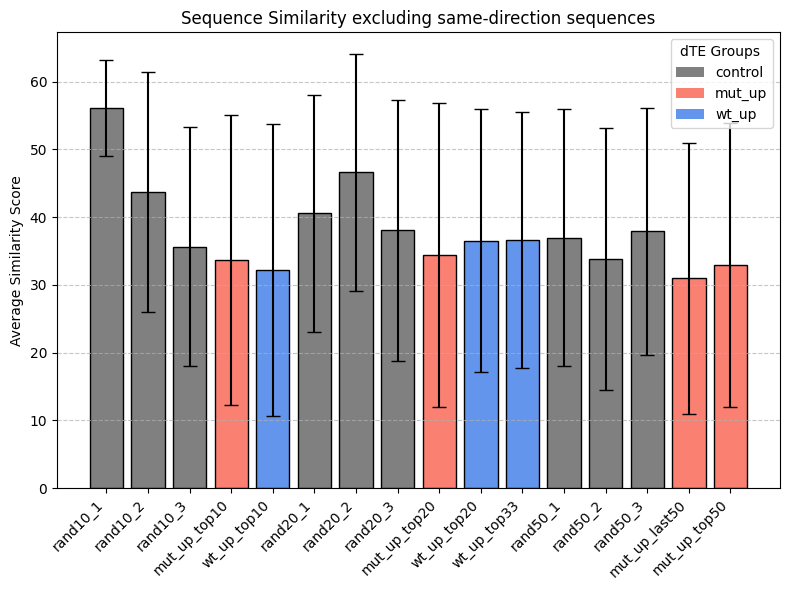

In [129]:
summary_df = squire_full_sum_df.copy()

bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['avg_pctIdentity'] , yerr=summary_df['std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')


plt.ylabel('Average Similarity Score')
plt.title('Sequence Similarity excluding same-direction sequences')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [116]:
squire_fw_exclusion_sum_df.head(2)

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,adjusted_std_pctIdentity,condition
rand10_1,55.99464,7.014331,8847.153169,30,435,158,20.338283,2.547734,control
rand10_2,44.038349,17.627964,5901.13882,30,435,134,13.565836,5.430223,control


In [117]:
squire_diff_dir_sum_df.head(2)

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,adjusted_std_pctIdentity,condition
rand10_1,55.695284,6.652145,7017.605846,30,435,126,16.132427,1.926828,control
rand10_2,44.775884,17.301571,4835.795451,30,435,108,11.116771,4.295562,control


In [130]:
squire_full_sum_df.head(2)

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,adjusted_std_pctIdentity,condition
rand10_1,56.103028,7.13755,9761.926831,30,435,174,22.441211,2.85502,control
rand10_2,43.767418,17.738312,6433.810505,30,435,147,14.790369,5.994326,control


## human TCPS data pipeline

In [135]:
tcps_fnames

0         tcps_ad_up_all_pairwise_identity.csv
1          tcps_rand10_1_pairwise_identity.csv
2          tcps_rand10_2_pairwise_identity.csv
3          tcps_rand10_3_pairwise_identity.csv
4          tcps_rand20_1_pairwise_identity.csv
5          tcps_rand20_2_pairwise_identity.csv
6          tcps_rand20_3_pairwise_identity.csv
7          tcps_rand50_1_pairwise_identity.csv
8          tcps_rand50_2_pairwise_identity.csv
9          tcps_rand50_3_pairwise_identity.csv
10    tcps_ser_up_last50_pairwise_identity.csv
11     tcps_ser_up_top10_pairwise_identity.csv
12     tcps_ser_up_top20_pairwise_identity.csv
13     tcps_ser_up_top50_pairwise_identity.csv
dtype: object

In [136]:
# load all df
tcps_df_ls = []
for f in tcps_fnames:
    d= pd.read_csv( result_dir + f, header = 0, index_col = None)
    tcps_df_ls.append( d)

In [143]:
# annotate
for d in tcps_df_ls:
    d = add_class_direction_info( d, tcps_repClass_dict )

In [145]:
tcps_fnames

0         tcps_ad_up_all_pairwise_identity.csv
1          tcps_rand10_1_pairwise_identity.csv
2          tcps_rand10_2_pairwise_identity.csv
3          tcps_rand10_3_pairwise_identity.csv
4          tcps_rand20_1_pairwise_identity.csv
5          tcps_rand20_2_pairwise_identity.csv
6          tcps_rand20_3_pairwise_identity.csv
7          tcps_rand50_1_pairwise_identity.csv
8          tcps_rand50_2_pairwise_identity.csv
9          tcps_rand50_3_pairwise_identity.csv
10    tcps_ser_up_last50_pairwise_identity.csv
11     tcps_ser_up_top10_pairwise_identity.csv
12     tcps_ser_up_top20_pairwise_identity.csv
13     tcps_ser_up_top50_pairwise_identity.csv
dtype: object

In [146]:
tcps_inds = ['AD_up'] + rand_inds + ['SER_up_last50']+ [ f'SER_up_top{n}' for n in [10,20,50] ]

In [148]:
assert( len( tcps_df_ls) == len( tcps_inds) )

In [149]:
tcps_inds

['AD_up',
 'rand10_1',
 'rand10_2',
 'rand10_3',
 'rand20_1',
 'rand20_2',
 'rand20_3',
 'rand50_1',
 'rand50_2',
 'rand50_3',
 'SER_up_last50',
 'SER_up_top10',
 'SER_up_top20',
 'SER_up_top50']

In [150]:
tcps_cond =  ['AD_up'] + ['control' for i in range(9) ] + ['SER_up' for i in range(4 )]

In [151]:
assert( len( tcps_df_ls) == len( tcps_cond) )

In [152]:
tcps_total_nums = [ 9 ] + [ 10 for i in range(3)] + [ 20 for i in range(3)] + [ 50 for i in range(3)]
tcps_total_nums = tcps_total_nums + [ 50, 10, 20, 50 ]

In [153]:
tcps_total_nums = pd.Series( tcps_total_nums)
tcps_total_nums = tcps_total_nums*3

In [154]:
tcps_total_nums

0      27
1      30
2      30
3      30
4      60
5      60
6      60
7     150
8     150
9     150
10    150
11     30
12     60
13    150
dtype: int64

In [156]:
# generate summary df from the full df
tcps_full_sum_df = seqComp.get_summary_df( tcps_df_ls, tcps_inds, tcps_cond, tcps_total_nums )

AD_up
Original df has 351 elements
Filtered df has 144 elements
0.41025641025641024 left

rand10_1
Original df has 435 elements
Filtered df has 174 elements
0.4 left

rand10_2
Original df has 435 elements
Filtered df has 192 elements
0.4413793103448276 left

rand10_3
Original df has 435 elements
Filtered df has 246 elements
0.5655172413793104 left

rand20_1
Original df has 1770 elements
Filtered df has 501 elements
0.2830508474576271 left

rand20_2
Original df has 1770 elements
Filtered df has 789 elements
0.4457627118644068 left

rand20_3
Original df has 1770 elements
Filtered df has 681 elements
0.3847457627118644 left

rand50_1
Original df has 11175 elements
Filtered df has 4074 elements
0.36456375838926175 left

rand50_2
Original df has 11175 elements
Filtered df has 4704 elements
0.42093959731543623 left

rand50_3
Original df has 11175 elements
Filtered df has 3822 elements
0.34201342281879193 left

SER_up_last50
Original df has 11175 elements
Filtered df has 3507 elements
0.31382

### get fw-fw exclusion summary df

In [159]:
# extract dfs
tcps_exfw_df_ls = []
for d in tcps_df_ls:
    d2 =  d[ (d['Direction1'] != 'fw') | (d['Direction2'] != 'fw' ) ]
    tcps_exfw_df_ls.append( d2)
    
    

In [178]:
tcps_exfw_df_ls[0].head(10)

,ID1,ID2,PercentIdentity,Alignment_str,ID1_original,ID2_original,Direction1,Direction2,repClass1,repClass2
0,L2c_97668_rvcmp,L2c_97668_cmp,64.285714,acatttat--tgacatctaccc--ac--tgcaag-tatagat-g--...,L2c_97668,L2c_97668,rvcmp,cmp,LINE,LINE
1,L2c_97668_rvcmp,L2c_97668,61.038961,a-catt-ta-ttgacatctacccactgcaagt-atagatgaataag...,L2c_97668,L2c_97668,rvcmp,fw,LINE,LINE
2,L2c_97668_rvcmp,L2b_80878_rvcmp,32.629108,ac--a--t-t-tatt---gaca-tcta---c---c--c----a---...,L2c_97668,L2b_80878,rvcmp,rvcmp,LINE,LINE
3,L2c_97668_rvcmp,L2b_80878_cmp,32.159624,a----cattta--------ttgac-a-----t-------c----t-...,L2c_97668,L2b_80878,rvcmp,cmp,LINE,LINE
4,L2c_97668_rvcmp,L2b_80878,32.394366,a-cat-t-tatt---gac--a--t-ct-----a-ccc-a--ctgc-...,L2c_97668,L2b_80878,rvcmp,fw,LINE,LINE
5,L2c_97668_rvcmp,AluJo_63739_rvcmp,56.790123,ac--atttattg-a--ca--t-cta----ccca--ctgca-agta-...,L2c_97668,AluJo_63739,rvcmp,rvcmp,LINE,SINE
6,L2c_97668_rvcmp,AluJo_63739_cmp,58.641975,acatttatt-gacatct-acc----c-actgca-a-gt--a--t-a...,L2c_97668,AluJo_63739,rvcmp,cmp,LINE,SINE
7,L2c_97668_rvcmp,AluJo_63739,58.641975,-acatttattgacatctaccc--a-ctgcaagt-ataga-tgaata...,L2c_97668,AluJo_63739,rvcmp,fw,LINE,SINE
8,L2c_97668_rvcmp,MSTB1_4089_rvcmp,37.662338,acatttattgacatctacc-cactg-caagtatagatgaataagac...,L2c_97668,MSTB1_4089,rvcmp,rvcmp,LINE,LTR
9,L2c_97668_rvcmp,MSTB1_4089_cmp,37.012987,acatttattgac-atct-acccactgcaagtatagatgaat--aa-...,L2c_97668,MSTB1_4089,rvcmp,cmp,LINE,LTR


In [160]:
# generate summary df from the dfs
tcps_fw_exclusion_sum_df = seqComp.get_summary_df( tcps_exfw_df_ls, tcps_inds, tcps_cond, tcps_total_nums )

AD_up
Original df has 315 elements
Filtered df has 131 elements
0.4158730158730159 left

rand10_1
Original df has 390 elements
Filtered df has 158 elements
0.40512820512820513 left

rand10_2
Original df has 390 elements
Filtered df has 174 elements
0.4461538461538462 left

rand10_3
Original df has 390 elements
Filtered df has 222 elements
0.5692307692307692 left

rand20_1
Original df has 1580 elements
Filtered df has 452 elements
0.28607594936708863 left

rand20_2
Original df has 1580 elements
Filtered df has 708 elements
0.4481012658227848 left

rand20_3
Original df has 1580 elements
Filtered df has 612 elements
0.38734177215189874 left

rand50_1
Original df has 9950 elements
Filtered df has 3638 elements
0.36562814070351757 left

rand50_2
Original df has 9950 elements
Filtered df has 4198 elements
0.4219095477386935 left

rand50_3
Original df has 9950 elements
Filtered df has 3414 elements
0.34311557788944724 left

SER_up_last50
Original df has 9950 elements
Filtered df has 3134 elem

In [161]:
tcps_fw_exclusion_sum_df.head(10)

,AD_up,rand10_1,rand10_2,rand10_3,rand20_1,rand20_2,rand20_3,rand50_1,rand50_2,rand50_3,SER_up_last50,SER_up_top10,SER_up_top20,SER_up_top50
avg_pctIdentity,43.289959,35.864959,46.695292,57.022751,46.450493,39.439949,34.310982,39.855858,42.238676,41.844644,42.988381,44.986318,52.633103,44.038041
std_pctIdentity,14.992087,21.74997,13.575207,12.512817,15.372942,20.537874,21.173496,18.04037,17.948953,18.994549,16.259286,18.280633,14.546371,17.00153
sum_pctIdentity,5670.984622,5666.663471,8124.980771,12659.050829,20995.622992,27923.483739,20998.320926,144995.610136,177317.962252,142857.615515,134725.58563,6388.057104,36422.107223,164790.348259
num_element_sampled,27,30,30,30,60,60,60,150,150,150,150,30,60,150
num_combination_all,351,435,435,435,1770,1770,1770,11175,11175,11175,11175,435,1770,11175
num_combination_left,131,158,174,222,452,708,612,3638,4198,3414,3134,142,692,3742
adjusted_avg_pctIdentity,16.156651,13.026813,18.678117,29.101266,11.861934,15.77598,11.863458,12.974999,15.867379,12.783679,12.055981,14.685189,20.577462,14.74634
adjusted_std_pctIdentity,5.595337,7.899989,5.430083,6.385852,3.925746,8.21515,7.321005,5.873008,6.742703,5.802898,4.559875,5.967471,5.687056,5.69304
condition,AD_up,control,control,control,control,control,control,control,control,control,SER_up,SER_up,SER_up,SER_up


### get diff-direction exclusion summary df

In [162]:
# extract dfs
tcps_diff_dir_df_ls = []
for d in tcps_df_ls:
    d2 =  d[ d['Direction1'] != d['Direction2']  ]
    tcps_diff_dir_df_ls.append( d2)
    
    

In [163]:
# generate summary df from the dfs
tcps_diff_dir_sum_df = seqComp.get_summary_df( tcps_diff_dir_df_ls, tcps_inds, tcps_cond, tcps_total_nums )

AD_up
Original df has 243 elements
Filtered df has 105 elements
0.43209876543209874 left

rand10_1
Original df has 300 elements
Filtered df has 126 elements
0.42 left

rand10_2
Original df has 300 elements
Filtered df has 138 elements
0.46 left

rand10_3
Original df has 300 elements
Filtered df has 174 elements
0.58 left

rand20_1
Original df has 1200 elements
Filtered df has 354 elements
0.295 left

rand20_2
Original df has 1200 elements
Filtered df has 546 elements
0.455 left

rand20_3
Original df has 1200 elements
Filtered df has 474 elements
0.395 left

rand50_1
Original df has 7500 elements
Filtered df has 2766 elements
0.3688 left

rand50_2
Original df has 7500 elements
Filtered df has 3186 elements
0.4248 left

rand50_3
Original df has 7500 elements
Filtered df has 2598 elements
0.3464 left

SER_up_last50
Original df has 7500 elements
Filtered df has 2388 elements
0.3184 left

SER_up_top10
Original df has 300 elements
Filtered df has 114 elements
0.38 left

SER_up_top20
Original

In [164]:
tcps_diff_dir_sum_df.head(10)

,AD_up,rand10_1,rand10_2,rand10_3,rand20_1,rand20_2,rand20_3,rand50_1,rand50_2,rand50_3,SER_up_last50,SER_up_top10,SER_up_top20,SER_up_top50
avg_pctIdentity,44.417886,36.736966,47.186649,54.195871,46.412255,39.805374,34.946282,39.441602,41.640911,41.13242,42.890122,45.447452,50.985237,43.377278
std_pctIdentity,15.269755,20.95891,13.325383,8.065474,14.764226,20.401159,21.022354,17.057442,16.919584,17.663149,15.758649,17.329814,12.071806,15.762129
sum_pctIdentity,4663.878021,4628.857751,6511.757605,9430.081611,16429.938386,21733.734274,16564.537539,109095.471415,132667.943672,106862.027641,102421.611221,5181.009527,27226.116686,123364.977483
num_element_sampled,27,30,30,30,60,60,60,150,150,150,150,30,60,150
num_combination_all,351,435,435,435,1770,1770,1770,11175,11175,11175,11175,435,1770,11175
num_combination_left,105,126,138,174,354,546,474,2766,3186,2598,2388,114,534,2844
adjusted_avg_pctIdentity,13.287402,10.641052,14.969558,21.678349,9.282451,12.278946,9.358496,9.762458,11.871852,9.562598,9.165245,11.910367,15.381987,11.039372
adjusted_std_pctIdentity,4.567875,6.070857,4.227363,3.226189,2.952845,6.293239,5.629715,4.222003,4.823785,4.106386,3.367486,4.541606,3.642002,4.011409
condition,AD_up,control,control,control,control,control,control,control,control,control,SER_up,SER_up,SER_up,SER_up


### generate avg. score plots

In [169]:
condition_colors = {
    'control': 'gray',
    'SER_up': 'salmon',
    'AD_up':'cornflowerblue'
}

In [166]:
tcps_fw_exclusion_sum_df = tcps_fw_exclusion_sum_df.T

In [167]:
tcps_fw_exclusion_sum_df.sort_values( by = [ 'num_element_sampled', 'condition'], inplace =True )

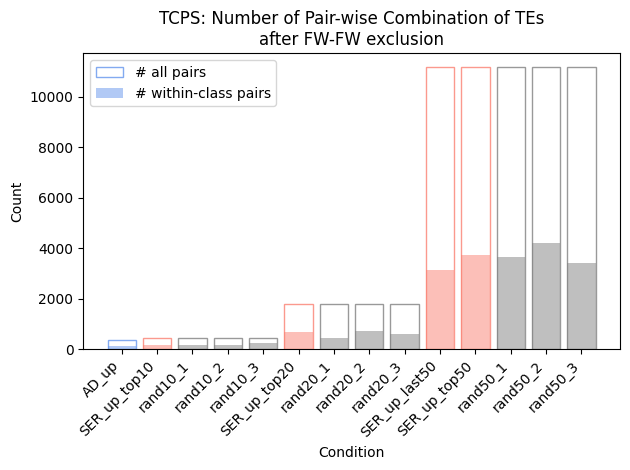

In [170]:
# Example data
summary_df = tcps_fw_exclusion_sum_df.copy()


x_pos = np.arange(summary_df.shape[0])
heights1 = summary_df['num_combination_all']  # dataset 1
heights2 = summary_df['num_combination_left' ]   # dataset 2

all_pair_colors = [condition_colors[cond] for cond in summary_df['condition'] ]


bar_width = 0.8 # need to adjust

# Plot side-by-side histograms
plt.bar(x_pos , heights1, width=bar_width, label='# all pairs', alpha=0.8, edgecolor=all_pair_colors, facecolor='none',)
plt.bar(x_pos , heights2, width=bar_width, label='# within-class pairs', alpha=0.5, color =all_pair_colors)

# Add labels and legend
plt.xticks(x_pos, summary_df.index, rotation = 45, ha = 'right')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('TCPS: Number of Pair-wise Combination of TEs\nafter FW-FW exclusion')
plt.legend()
plt.tight_layout()
plt.show()


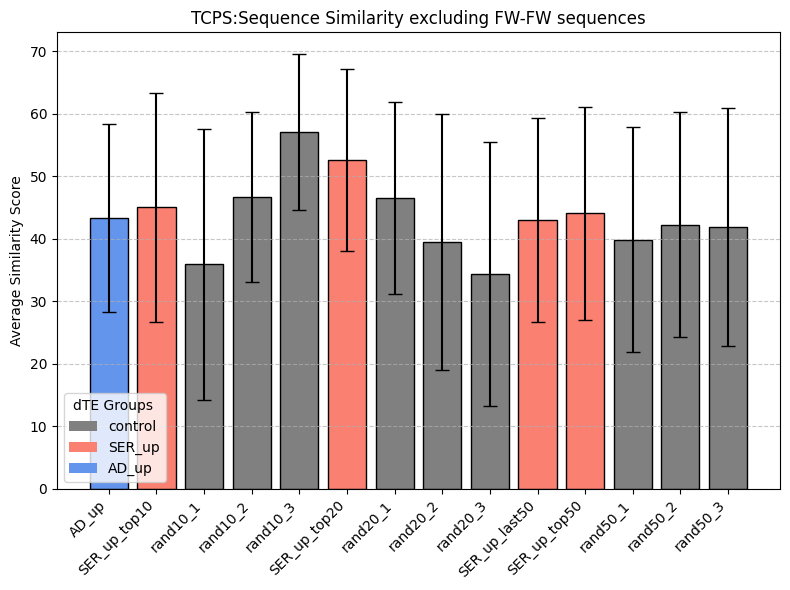

In [171]:
summary_df = tcps_fw_exclusion_sum_df.copy()

bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['avg_pctIdentity'] , yerr=summary_df['std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')


plt.ylabel('Average Similarity Score')
plt.title('TCPS:Sequence Similarity excluding FW-FW sequences')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [175]:
tcps_fw_exclusion_sum_df.head()

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,adjusted_std_pctIdentity,condition
AD_up,43.289959,14.992087,5670.984622,27,351,131,16.156651,5.595337,AD_up
SER_up_top10,44.986318,18.280633,6388.057104,30,435,142,14.685189,5.967471,SER_up
rand10_1,35.864959,21.74997,5666.663471,30,435,158,13.026813,7.899989,control
rand10_2,46.695292,13.575207,8124.980771,30,435,174,18.678117,5.430083,control
rand10_3,57.022751,12.512817,12659.050829,30,435,222,29.101266,6.385852,control


In [176]:
tcps_full_sum_df = tcps_full_sum_df.T
tcps_full_sum_df.sort_values( by = [ 'num_element_sampled', 'condition'], inplace =True )

In [177]:
tcps_full_sum_df.head()

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,adjusted_std_pctIdentity,condition
AD_up,42.878736,14.868415,6174.537923,27,351,144,17.591276,6.099862,AD_up
SER_up_top10,44.817826,18.61228,6991.580892,30,435,156,16.0726,6.674749,SER_up
rand10_1,35.549232,22.020211,6185.566331,30,435,174,14.219693,8.808084,control
rand10_2,46.51871,13.659351,8931.592354,30,435,192,20.532396,6.028955,control
rand10_3,58.022502,13.602979,14273.535438,30,435,246,32.812725,7.692719,control


In [172]:
tcps_diff_dir_sum_df = tcps_diff_dir_sum_df.T

In [173]:
tcps_diff_dir_sum_df.sort_values( by = [ 'num_element_sampled', 'condition'], inplace =True )

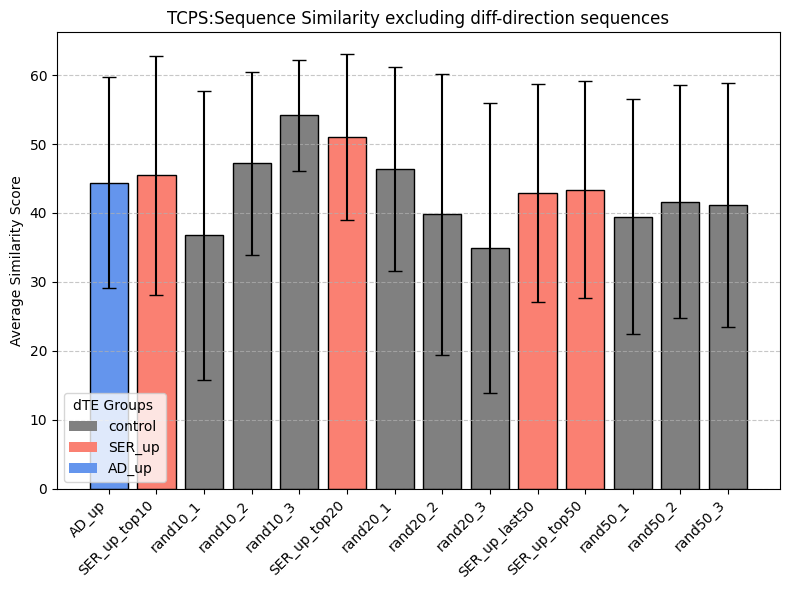

In [174]:
summary_df = tcps_diff_dir_sum_df.copy()

bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['avg_pctIdentity'] , yerr=summary_df['std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')


plt.ylabel('Average Similarity Score')
plt.title('TCPS:Sequence Similarity excluding diff-direction sequences')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


## check if the transcript direction combination shows differential similarity score distribution

In [180]:
import itertools

### get direction contribution separated scores

In [186]:
squire_df_ls[0].head()

,ID1,ID2,PercentIdentity,Alignment_str,ID1_original,ID2_original,Direction1,Direction2,repClass1,repClass2
0,8873_IAPLTR1a_Mm_rvcmp,8873_IAPLTR1a_Mm_cmp,64.391691,tgttatt-agacgcgttctcacga-c-cggccag-ga-aagacg-c...,8873_IAPLTR1a_Mm,8873_IAPLTR1a_Mm,rvcmp,cmp,LTR,LTR
1,8873_IAPLTR1a_Mm_rvcmp,8873_IAPLTR1a_Mm,65.281899,tgttattag--a-c-gcgttctcacgac---cggccagg--a-aag...,8873_IAPLTR1a_Mm,8873_IAPLTR1a_Mm,rvcmp,fw,LTR,LTR
2,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int_rvcmp,15.911237,--t--------g------------tta-t-t-a-------g-----...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,rvcmp,LTR,LTR
3,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int_cmp,15.911237,t---g----t----t-------------a-----------------...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,cmp,LTR,LTR
4,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int,15.911237,--tg----t--t--a-------------tt----------------...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,fw,LTR,LTR


In [181]:
elements = ['fw' ,'cmp', 'rvcmp']

In [222]:
all_combinations = itertools.combinations_with_replacement(elements, 2)
ALL_DIRECTION_PAIRS = list( all_combinations ) # a list of tuples 

#### get direction pair column

In [187]:
('fw','fw') in all_direction_pairs

True

In [188]:
('fw','cmp')[::-1]

('cmp', 'fw')

In [191]:
test_df = squire_df_ls[0].copy()
direction_pair_ls = []

for i in test_df.index:
    curr_pair = tuple( [test_df.loc[i]['Direction1'], test_df.loc[i]['Direction2']] )
    if( curr_pair in all_direction_pairs):
        direction_pair_ls.append( curr_pair)
    else:
        direction_pair_ls.append( curr_pair[::-1]  )

In [192]:
direction_pair_ls[0:5]

[('cmp', 'rvcmp'),
 ('fw', 'rvcmp'),
 ('rvcmp', 'rvcmp'),
 ('cmp', 'rvcmp'),
 ('fw', 'rvcmp')]

In [193]:
direction_str_ls = [ f'{t[0]}_{t[1]}' for t in direction_pair_ls ]

In [194]:
direction_str_ls[0:5]

['cmp_rvcmp', 'fw_rvcmp', 'rvcmp_rvcmp', 'cmp_rvcmp', 'fw_rvcmp']

In [195]:
test_df['direction_str'] = direction_str_ls

In [196]:
test_df.head()

,ID1,ID2,PercentIdentity,Alignment_str,ID1_original,ID2_original,Direction1,Direction2,repClass1,repClass2,direction_str
0,8873_IAPLTR1a_Mm_rvcmp,8873_IAPLTR1a_Mm_cmp,64.391691,tgttatt-agacgcgttctcacga-c-cggccag-ga-aagacg-c...,8873_IAPLTR1a_Mm,8873_IAPLTR1a_Mm,rvcmp,cmp,LTR,LTR,cmp_rvcmp
1,8873_IAPLTR1a_Mm_rvcmp,8873_IAPLTR1a_Mm,65.281899,tgttattag--a-c-gcgttctcacgac---cggccagg--a-aag...,8873_IAPLTR1a_Mm,8873_IAPLTR1a_Mm,rvcmp,fw,LTR,LTR,fw_rvcmp
2,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int_rvcmp,15.911237,--t--------g------------tta-t-t-a-------g-----...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,rvcmp,LTR,LTR,rvcmp_rvcmp
3,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int_cmp,15.911237,t---g----t----t-------------a-----------------...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,cmp,LTR,LTR,cmp_rvcmp
4,8873_IAPLTR1a_Mm_rvcmp,279_RLTR4_MM-int,15.911237,--tg----t--t--a-------------tt----------------...,8873_IAPLTR1a_Mm,279_RLTR4_MM-int,rvcmp,fw,LTR,LTR,fw_rvcmp


In [206]:
test_df['direction_str'].unique()

array(['cmp_rvcmp', 'fw_rvcmp', 'rvcmp_rvcmp', 'fw_cmp', 'cmp_cmp',
       'fw_fw'], dtype=object)

### generate distribution plot for the identity score separated by direction pairs

/tmp/ipykernel_71438/4088185596.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot( data = test_df, x ='direction_str', y = 'PercentIdentity', palette='colorblind',   alpha = 0.8  )


<Axes: xlabel='direction_str', ylabel='PercentIdentity'>

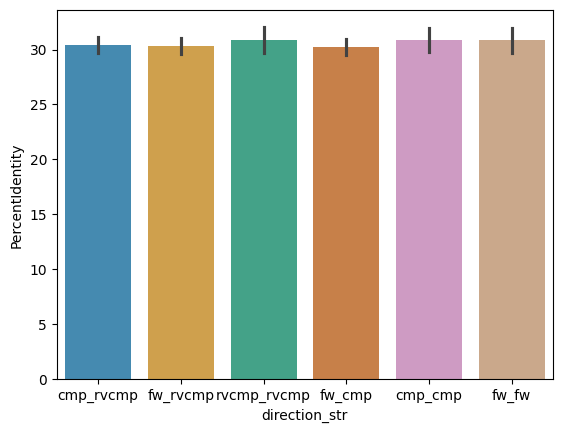

In [205]:
sn.barplot( data = test_df, x ='direction_str', y = 'PercentIdentity', palette='colorblind',   alpha = 0.8  )

In [208]:
test_sum_df = test_df[['direction_str', 'PercentIdentity']].groupby('direction_str').mean()

In [212]:
test_sum_df = test_sum_df.T

In [221]:
test_sum_df[ ['fw_fw', 'cmp_cmp', 'rvcmp_rvcmp', 'fw_rvcmp', 'fw_cmp', 'cmp_rvcmp', ]].iloc[0]

direction_str
fw_fw          30.864983
cmp_cmp        30.864983
rvcmp_rvcmp    30.864983
fw_rvcmp       30.349438
fw_cmp         30.214710
cmp_rvcmp      30.380405
Name: PercentIdentity, dtype: float64

### batch dirction-wise score distribution

In [225]:
def get_direction_wise_summary_df(df_ls,df_index_names, conditions, num_elements_sampled, verbose = True):
    summary_df = pd.DataFrame(index = ['fw_fw', 'cmp_cmp', 'rvcmp_rvcmp',
                                       'fw_rvcmp', 'fw_cmp', 'cmp_rvcmp', 'condition'])

    # filter the result df to contain only same-class TEs
    same_class_df_ls = seqComp.keep_within_class_TE_pairs( df_ls, df_index_names,  verbose = verbose)
    print( len( same_class_df_ls))


    for i,df in enumerate( same_class_df_ls):
        # get data meta information
        f_id = df_index_names[i]

        #add direction string to the df
        direction_pair_ls = []
        for j in df.index:
            curr_pair = tuple( [df.loc[j]['Direction1'], df.loc[j]['Direction2']] )
            if( curr_pair in ALL_DIRECTION_PAIRS):
                direction_pair_ls.append( curr_pair)
            else:
                direction_pair_ls.append( curr_pair[::-1]  )
        direction_str_ls = [ f'{t[0]}_{t[1]}' for t in direction_pair_ls ]
        df['direction_str'] = direction_str_ls
        
                
        #get avg score separated by direction strings
        curr_sum_df = df[['direction_str', 'PercentIdentity']].groupby('direction_str').mean()
        curr_sum_df = curr_sum_df.T
        direction_wise_scores = curr_sum_df.loc[ 'PercentIdentity', summary_df.index[0:-1]]
        
    
        # add result to the result df
        summary_df[ f_id ] = list( direction_wise_scores) + [conditions[i] ]
        #print( summary_df.shape)
    
    return summary_df
    

In [226]:
squire_direction_sum_df = get_direction_wise_summary_df(squire_df_ls, squire_f_inds, squire_cond, squire_total_nums, verbose = True)

mut_up_last50
Original df has 11175 elements
Filtered df has 8718 elements
0.7801342281879194 left

mut_up_top10
Original df has 435 elements
Filtered df has 354 elements
0.8137931034482758 left

mut_up_top20
Original df has 1770 elements
Filtered df has 1311 elements
0.7406779661016949 left

mut_up_top50
Original df has 11175 elements
Filtered df has 9114 elements
0.8155704697986578 left

rand10_1
Original df has 435 elements
Filtered df has 174 elements
0.4 left

rand10_2
Original df has 435 elements
Filtered df has 147 elements
0.33793103448275863 left

rand10_3
Original df has 435 elements
Filtered df has 282 elements
0.6482758620689655 left

rand20_1
Original df has 1770 elements
Filtered df has 762 elements
0.43050847457627117 left

rand20_2
Original df has 1770 elements
Filtered df has 681 elements
0.3847457627118644 left

rand20_3
Original df has 1770 elements
Filtered df has 645 elements
0.3644067796610169 left

rand50_1
Original df has 11175 elements
Filtered df has 4344 elem

/tmp/ipykernel_71438/2045907527.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction_str'] = direction_str_ls
/tmp/ipykernel_71438/2045907527.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction_str'] = direction_str_ls
/tmp/ipykernel_71438/2045907527.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [227]:
squire_direction_sum_df.head()

,mut_up_last50,mut_up_top10,mut_up_top20,mut_up_top50,rand10_1,rand10_2,rand10_3,rand20_1,rand20_2,rand20_3,rand50_1,rand50_2,rand50_3,wt_up_top10,wt_up_top20,wt_up_top33
fw_fw,31.434792,32.527466,36.31588,34.631975,57.173354,40.974745,32.676136,39.63875,46.86418,37.017397,36.758182,33.260531,37.311473,26.551235,35.150159,36.372366
cmp_cmp,31.434792,32.527466,36.31588,34.631975,57.173354,40.974745,32.676136,39.63875,46.86418,37.017397,36.758182,33.260531,37.311473,26.551235,35.150159,36.372366
rvcmp_rvcmp,31.434792,32.527466,36.31588,34.631975,57.173354,40.974745,32.676136,39.63875,46.86418,37.017397,36.758182,33.260531,37.311473,26.551235,35.150159,36.372366
fw_rvcmp,30.772063,34.287853,33.856624,32.319291,56.13482,45.056411,36.955319,41.042375,46.82128,38.545806,37.148635,34.061896,38.304318,34.401907,37.198321,36.766919
fw_cmp,30.619683,33.922527,33.257426,32.071532,54.980328,44.042769,36.601345,40.765555,46.232176,38.275222,36.897185,33.780738,37.961751,34.181315,36.824012,36.549609


In [228]:
squire_direction_sum_df = squire_direction_sum_df.T
squire_direction_sum_df.head()

,fw_fw,cmp_cmp,rvcmp_rvcmp,fw_rvcmp,fw_cmp,cmp_rvcmp,condition
mut_up_last50,31.434792,31.434792,31.434792,30.772063,30.619683,30.826468,mut_up
mut_up_top10,32.527466,32.527466,32.527466,34.287853,33.922527,34.097962,mut_up
mut_up_top20,36.31588,36.31588,36.31588,33.856624,33.257426,33.552503,mut_up
mut_up_top50,34.631975,34.631975,34.631975,32.319291,32.071532,32.237696,mut_up
rand10_1,57.173354,57.173354,57.173354,56.13482,54.980328,55.970705,control


In [229]:
squire_cond_unique  = squire_direction_sum_df['condition'].unique()

/tmp/ipykernel_71438/2573960957.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sn.barplot( data = squire_direction_sum_df.iloc[:, 0:-1], errorbar=("sd"), capsize = 0.1, alpha = 0.7, errwidth = 1 )


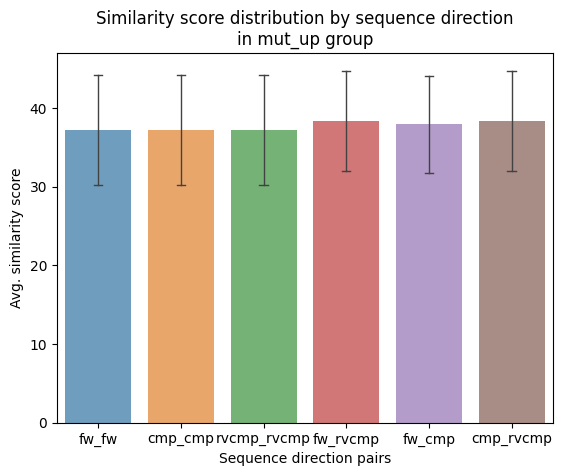

/tmp/ipykernel_71438/2573960957.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sn.barplot( data = squire_direction_sum_df.iloc[:, 0:-1], errorbar=("sd"), capsize = 0.1, alpha = 0.7, errwidth = 1 )


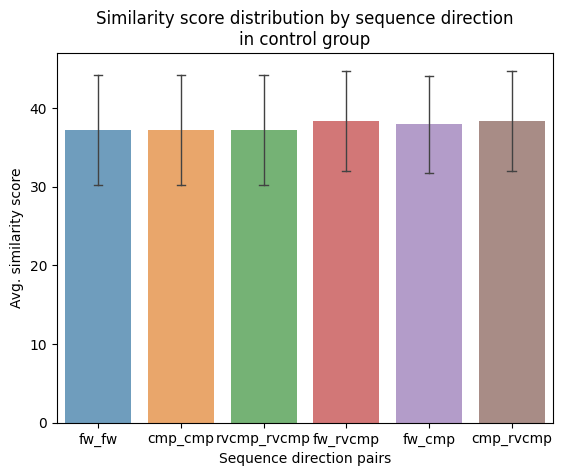

/tmp/ipykernel_71438/2573960957.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sn.barplot( data = squire_direction_sum_df.iloc[:, 0:-1], errorbar=("sd"), capsize = 0.1, alpha = 0.7, errwidth = 1 )


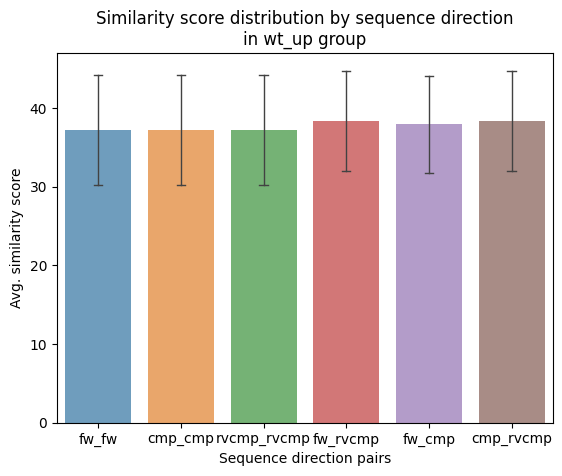

In [235]:
for c in squire_cond_unique:
    subdf = squire_direction_sum_df[ squire_direction_sum_df['condition'] ==c ]
    sn.barplot( data = squire_direction_sum_df.iloc[:, 0:-1], errorbar=("sd"), capsize = 0.1, alpha = 0.7, errwidth = 1 )
    plt.title( f'Similarity score distribution by sequence direction\nin {c} group')
    plt.ylabel('Avg. similarity score')
    plt.xlabel( 'Sequence direction pairs' )
    plt.show()